# Network HPM "table"
adapted from https://github.com/DifferentiableUniverseInitiative/Baryonator/blob/main/notebooks/HPM_test_on_CAMELS.ipynb
Implement the mapping from local density and scalar force to pressure and temperature (see https://arxiv.org/abs/2107.04606) as a neural network that learns the mean response.

In [1]:
import h5py, os, tqdm
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import optax
from flax import nnx
import orbax.checkpoint as ocp

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from jaxpm.painting import cic_paint, cic_read, compensate_cic
from jaxpm.utils import power_spectrum
from jaxpm.utils import _initialize_pk
from jaxpm.pm import linear_field, lpt, make_ode_fn, pm_forces
from jaxpm.kernels import fftk, gradient_kernel, invlaplace_kernel, longrange_kernel

jax.devices("gpu")

[cuda(id=0)]

In [2]:
# This will define the mesh size we use to make 3d density maps 
# Note that the physical size of the volume is 25 Mpc/h on the side
# so one voxel is 25/128 Mpc/h on the side
mesh_shape = 3 * [128]

## Loading the snapshots

In [3]:
%%time
SIM = "/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_066.hdf5"

# First, the full hydro run
data         = h5py.File(SIM, 'r')
BoxSize      = data['Header'].attrs[u'BoxSize']/1e3    #size of the snapshot in comoving Mpc/h
redshift     = data['Header'].attrs[u'Redshift']       #reshift of the snapshot
scale_factor = data['Header'].attrs[u'Time']           #scale factor
h            = data['Header'].attrs[u'HubbleParam']    #value of the hubble parameter in 100 km/s/(Mpc/h)
Masses       = data['Header'].attrs[u'MassTable']*1e10 #masses of the particles in Msun/h
Np           = data['Header'].attrs[u'NumPart_Total']  #total number of particles for specie
Omega_m      = data['Header'].attrs[u'Omega0']
Omega_L      = data['Header'].attrs[u'OmegaLambda']
Omega_b      = data['Header'].attrs[u'OmegaBaryon']

# Loading the DM particles
hydro_dm_pos = data['PartType1/Coordinates'][:]/1e3  #Mpc/h
hydro_dm_pos = (hydro_dm_pos/BoxSize*mesh_shape[0])   #Rescaling positions to grid coordinates
hydro_dm_rho = cic_read(cic_paint(jnp.zeros(mesh_shape), hydro_dm_pos), hydro_dm_pos) # computing density

# Loading the gas particles
hydro_gas_pos  = data['PartType0/Coordinates'][:]/1e3 #Mpc/h
hydro_gas_pos = (hydro_gas_pos/BoxSize*mesh_shape[0]) #Rescaling positions to grid coordinates
hydro_gas_mass = data['PartType0/Masses'][:]*1e10     #Msun/h 
hydro_gas_rho = data['/PartType0/Density'][:]*1e10 * (1e3)**3 #(Msun/h)/(Mpc/h)^3
hydro_gas_U   = data['/PartType0/InternalEnergy'][:]  #(km/s)^2
hydro_gas_ne  = data['/PartType0/ElectronAbundance'][:]
# Derive pressure
gamma = 5.0/3.0
hydro_gas_P = (gamma-1.0)*hydro_gas_U*hydro_gas_rho #units are (Msun/h)*(km/s)^2/(Mpc/h)^3
# And temperature
yhelium = 0.0789
BOLTZMANN  = 1.38065e-16         #erg/K - NIST 2010
PROTONMASS = 1.67262178e-24      #gram  - NIST 2010
hydro_gas_T = hydro_gas_U*(1.0 + 4.0*yhelium)/(1.0 + yhelium + hydro_gas_ne)*1e10*(2.0/3.0)
hydro_gas_T *= (PROTONMASS/BOLTZMANN)
data.close()
# Utility functions from the CAMELS library https://github.com/franciscovillaescusa/CAMELS/blob/master/library/camels_library.py

# Computing total rho and fscalar
hydro_tot_rho = cic_paint(jnp.zeros(mesh_shape), hydro_dm_pos)
hydro_tot_rho = cic_paint(hydro_tot_rho, hydro_gas_pos, 
                                weight=hydro_gas_mass/Masses[1])

hydro_dm_rhotot = cic_read(hydro_tot_rho, hydro_dm_pos)
hydro_gas_rhotot = cic_read(hydro_tot_rho, hydro_gas_pos)

# And compute this scalar force 
kvec = fftk(mesh_shape)
delta_k = jnp.fft.rfftn(hydro_tot_rho)
kk = sum(ki**2 for ki in kvec)
kk[kk == 0] = 1.
delta_k = delta_k / jnp.sqrt(kk)

hydro_dm_fscalar = cic_read(jnp.fft.irfftn(delta_k), hydro_dm_pos)
hydro_gas_fscalar = cic_read(jnp.fft.irfftn(delta_k), hydro_gas_pos)

CPU times: user 3.23 s, sys: 1.32 s, total: 4.56 s
Wall time: 5.92 s


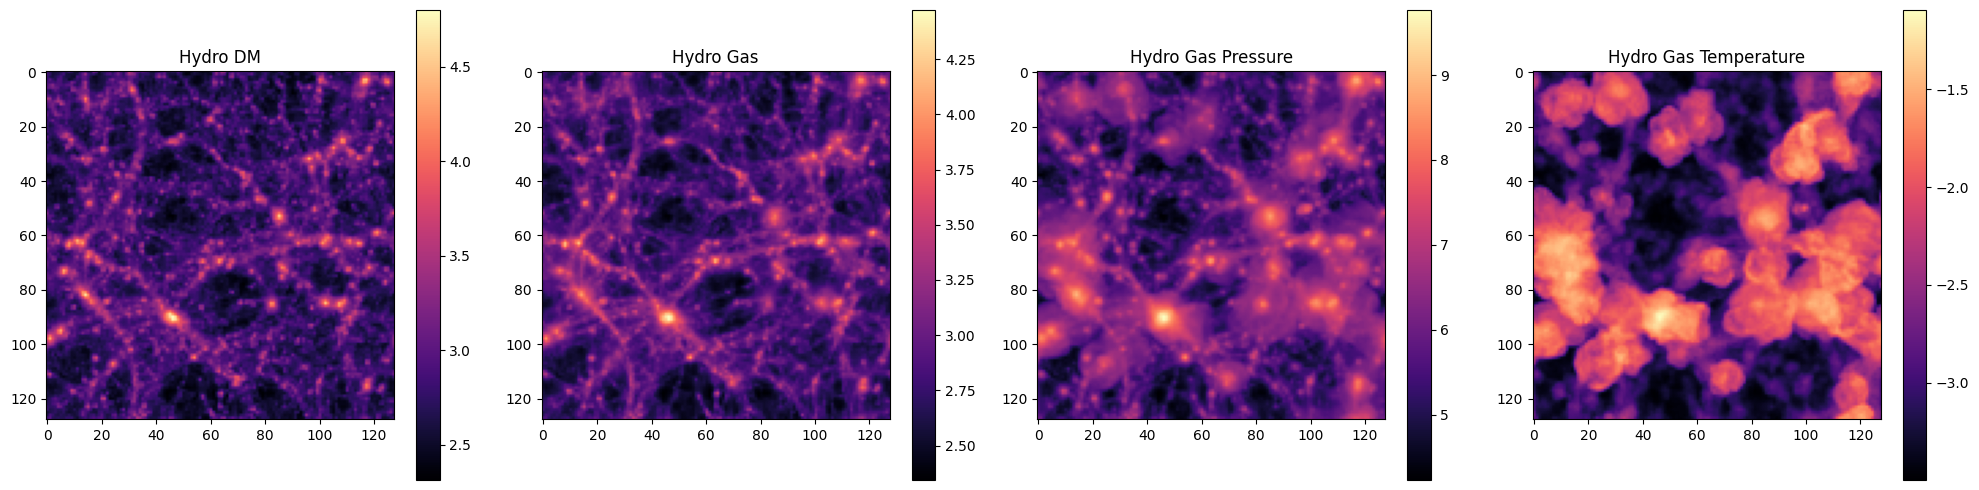

In [4]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

im0 = ax[0].imshow(np.log10(cic_paint(jnp.zeros(mesh_shape), hydro_dm_pos).sum(axis=0)), cmap='magma')
ax[0].set(title='Hydro DM')
fig.colorbar(im0, ax=ax[0])

im1 = ax[1].imshow(np.log10(cic_paint(jnp.zeros(mesh_shape), hydro_gas_pos).sum(axis=0)), cmap='magma')
ax[1].set(title='Hydro Gas')
fig.colorbar(im1, ax=ax[1])

im2 = ax[2].imshow(np.log10(cic_paint(jnp.zeros(mesh_shape), hydro_gas_pos, hydro_gas_P/hydro_gas_rho).sum(axis=0)), cmap='magma')
ax[2].set(title='Hydro Gas Pressure')
fig.colorbar(im2, ax=ax[2])

im3 = ax[3].imshow(np.log10(cic_paint(jnp.zeros(mesh_shape), hydro_gas_pos, hydro_gas_T/hydro_gas_rho).sum(axis=0)), cmap='magma')
ax[3].set(title='Hydro Gas Temperature')
fig.colorbar(im3, ax=ax[3])

fig.tight_layout()

## Testing correspondance between local environment and P/T

In [5]:
X = jnp.stack([np.log10(hydro_gas_rhotot),np.arcsinh(hydro_gas_fscalar/100)], axis=-1)
Y = jnp.stack([np.log10(hydro_gas_P), np.log10(hydro_gas_T)], axis=-1)

d_X = X.shape[-1]
d_Y = Y.shape[-1]

# X_scaler = StandardScaler()
# X_scaled = X_scaler.fit_transform(X)

# Y_scaler = StandardScaler()
# Y_scaled = Y_scaler.fit_transform(Y)

X_scaled = X
Y_scaled = Y

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.003, random_state=42)

print(f"{X_train.shape[0]} training samples")
print(f"{X_test.shape[0]} test samples")

15906890 training samples
47865 test samples


In [6]:
class MLP(nnx.Module):
    def __init__(self, d_in: int, d_out: int, d_hidden: int, n_hidden: int, rngs: nnx.Rngs, activation=jax.nn.relu):
        self.linear_in = nnx.Linear(d_in, d_hidden, rngs=rngs)
        self.linear_hid = [nnx.Linear(d_hidden, d_hidden, rngs=rngs) for _ in range(n_hidden)]
        self.linear_out = nnx.Linear(d_hidden, d_out, rngs=rngs)
        self.activation = activation
    
    def __call__(self, x):
        x = self.activation(self.linear_in(x))
        for layer in self.linear_hid:
            x = self.activation(layer(x))
        x = self.linear_out(x)
        return x

In [7]:
model = MLP(d_X, d_Y, 512, 4, nnx.Rngs(0))

total_steps = 10_000
batch_size = 1024

# lr_scheduler = optax.piecewise_constant_schedule(
#     init_value=1e-3,
#     boundaries_and_scales={int(total_steps*0.3): 0.2, int(total_steps*0.6): 0.1,}
# )
lr_scheduler = optax.cosine_decay_schedule(init_value=1e-3, decay_steps=total_steps, alpha=0.0)
momentum = 0.9
adam = optax.adamw(lr_scheduler, momentum)

# training

### @nnx.jit

In [8]:
# optimizer = nnx.Optimizer(model, adam)

# @nnx.jit
# def train_step(model, optimizer, batch):
#     x, y = batch

#     def loss_fn(model):
#         y_pred = model(x)
#         return jnp.mean((y - y_pred) **2)
    
#     loss, grads = nnx.value_and_grad(loss_fn)(model)
#     optimizer.update(grads)

#     return loss

# losses = []
# for i in tqdm.tqdm(range(total_steps)):
#     inds = np.random.choice(X_train.shape[0], batch_size)
#     batch = (X_train[inds], Y_train[inds])
    
#     loss = train_step(model, optimizer, batch)
#     losses.append(loss)

# fig, ax = plt.subplots()
# ax.plot(losses[100:])
# ax.set(yscale="log")

### @jax.jit (with nnx.split)

100%|██████████| 10000/10000 [00:26<00:00, 383.16it/s]


[None]

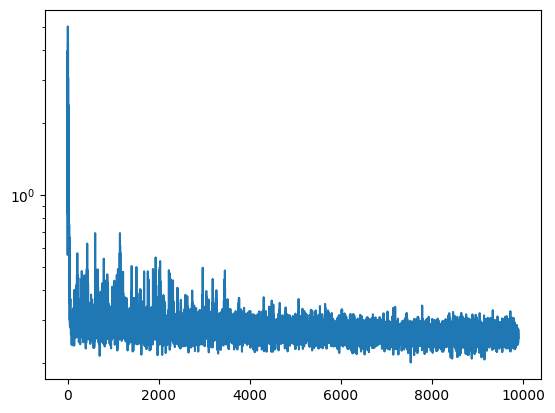

In [9]:
graphdef, params = nnx.split(model)
opt_state = adam.init(params)

@jax.jit
def train_step(params, opt_state, batch):
    x, y = batch

    def loss_fn(params):
        model = nnx.merge(graphdef, params)
        y_pred = model(x)
        loss = jnp.mean((y - y_pred) ** 2)
        return loss
    
    loss, grads = jax.value_and_grad(loss_fn)(params)

    updates, opt_state = adam.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    return params, opt_state, loss

losses = []
for i in tqdm.tqdm(range(total_steps)):
    inds = np.random.choice(X_train.shape[0], batch_size)
    batch = (X_train[inds], Y_train[inds])
    
    params, opt_state, loss = train_step(params, opt_state, batch)
    losses.append(loss)

model = nnx.merge(graphdef, params)

fig, ax = plt.subplots()
ax.plot(losses[100:])
ax.set(yscale="log")

### checkpointing

In [10]:
# see https://flax.readthedocs.io/en/latest/guides/checkpointing.html
checkpoint_file = os.path.join(os.getcwd(), "checkpoints/hpm_mlp.jx")
checkpointer = ocp.StandardCheckpointer()

In [11]:
_, params = nnx.split(model)
checkpointer.save(checkpoint_file, params, force=True)

In [12]:
# abstract_model = nnx.eval_shape(lambda: model)
# graphdef, abstract_params = nnx.split(abstract_model)

# params = checkpointer.restore(checkpoint_file, abstract_params)
# model = nnx.merge(graphdef, params)

# testing

### scatter plots

In [13]:
preds = []
for i in tqdm.tqdm(range(X_test.shape[0]//batch_size)): 
    preds.append(model(X_test[i*batch_size:(i+1)*batch_size]))
preds.append(model(X_test[(i+1)*batch_size:]))
preds = jnp.concatenate(preds, axis=0)

100%|██████████| 46/46 [00:00<00:00, 123.85it/s]


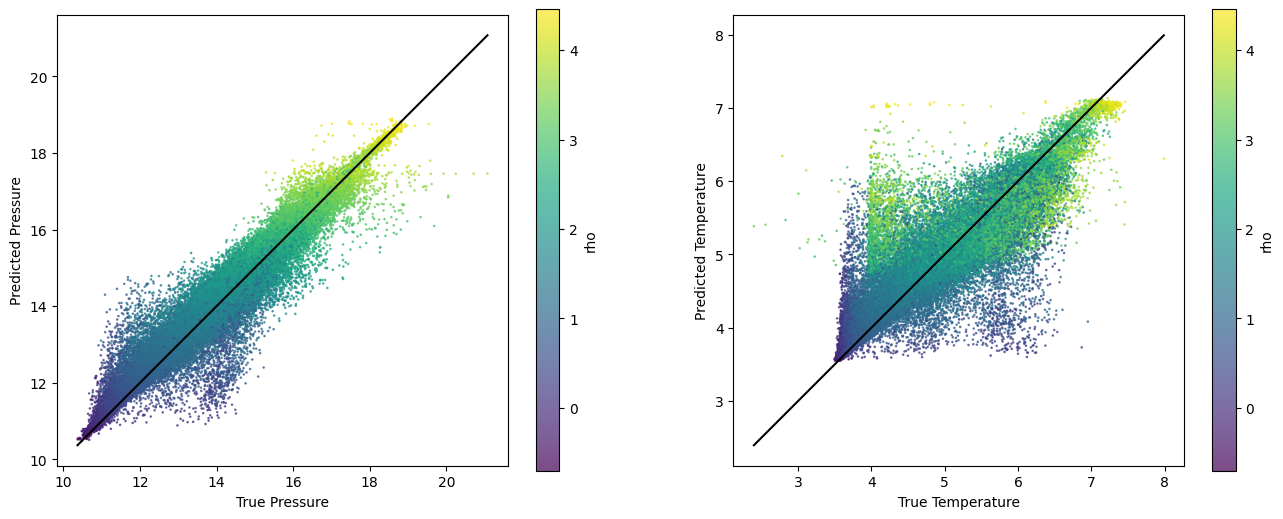

In [14]:
plt.figure(figsize=[16,6])

plt.subplot(121)
sc1 = plt.scatter(Y_test[:,0], preds[:,0], c=X_test[:,0], s=0.75, alpha=0.7)
plt.colorbar(sc1, label="rho")
plt.xlabel('True Pressure')
plt.ylabel('Predicted Pressure')
plt.plot([Y_test[:,0].min(), Y_test[:,0].max()], [Y_test[:,0].min(), Y_test[:,0].max()], color='k')
plt.gca().set_aspect('equal')

plt.subplot(122)
sc2 = plt.scatter(Y_test[:,1], preds[:,1], c=X_test[:,0], s=0.75, alpha=0.7)
plt.colorbar(sc2, label="rho")
plt.xlabel('True Temperature')
plt.ylabel('Predicted Temperature')
plt.plot([Y_test[:,1].min(), Y_test[:,1].max()], [Y_test[:,1].min(), Y_test[:,1].max()], color='k')
plt.gca().set_aspect('equal')

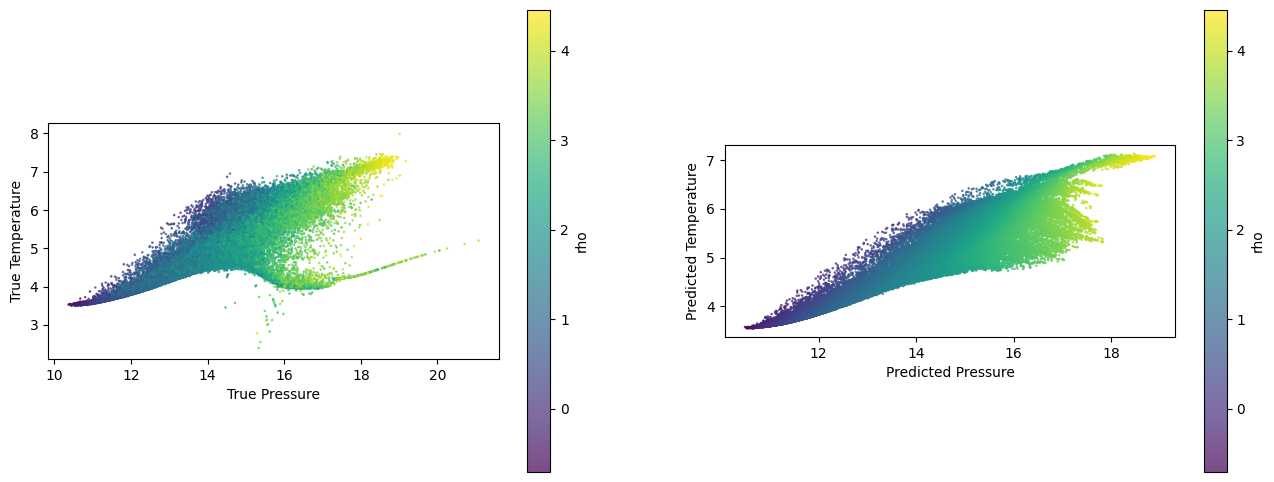

In [15]:
plt.figure(figsize=[16,6])

plt.subplot(121)
sc1 = plt.scatter(Y_test[:,0], Y_test[:,1], c=X_test[:,0], s=0.75, alpha=0.7)
plt.colorbar(sc1, label="rho")
plt.xlabel('True Pressure')
plt.ylabel('True Temperature')
plt.gca().set_aspect('equal')

plt.subplot(122)
sc2 = plt.scatter(preds[:,0], preds[:,1], c=X_test[:,0], s=0.75, alpha=0.7)
plt.colorbar(sc2, label="rho")
plt.xlabel('Predicted Pressure')
plt.ylabel('Predicted Temperature')
plt.gca().set_aspect('equal')

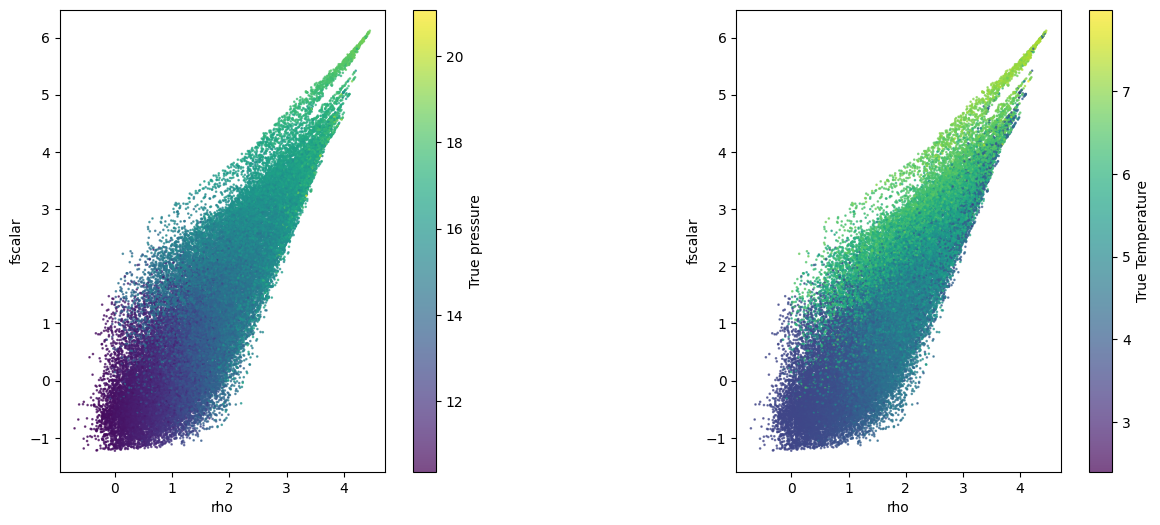

In [16]:
plt.figure(figsize=[16,6])

plt.subplot(121)
sc1 = plt.scatter(X_test[:,0], X_test[:,1], c=Y_test[:,0], s=0.75, alpha=0.7)
plt.colorbar(sc1, label="True pressure")
plt.xlabel('rho')
plt.ylabel('fscalar')
plt.gca().set_aspect('equal')

plt.subplot(122)
sc2 = plt.scatter(X_test[:,0], X_test[:,1], c=Y_test[:,1], s=0.75, alpha=0.7)
plt.colorbar(sc2, label="True Temperature")
plt.xlabel('rho')
plt.ylabel('fscalar')
plt.gca().set_aspect('equal')

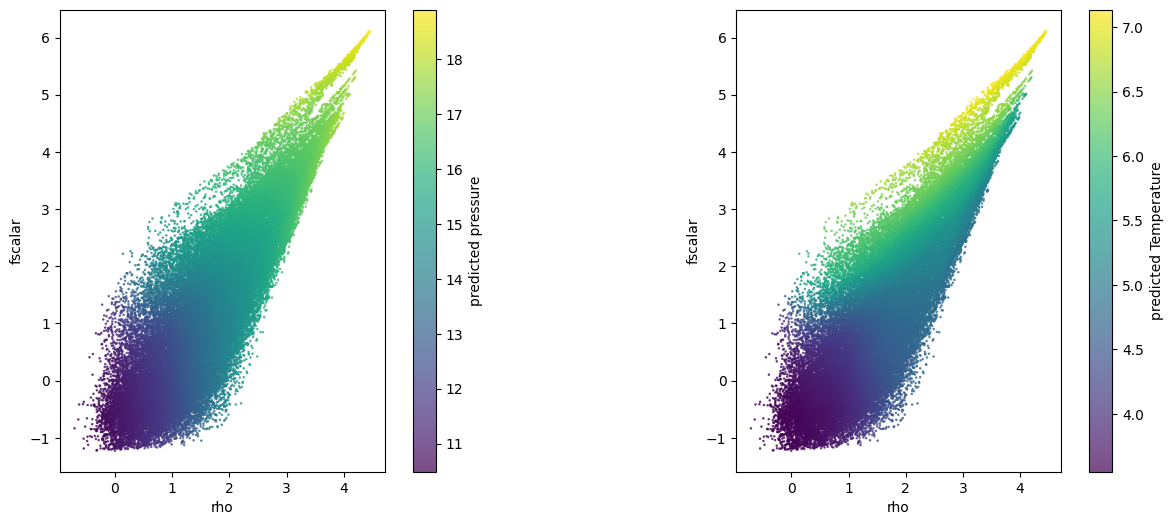

In [17]:
plt.figure(figsize=[16,6])

plt.subplot(121)
sc1 = plt.scatter(X_test[:,0], X_test[:,1], c=preds[:,0], s=0.75, alpha=0.7)
plt.colorbar(sc1, label="predicted pressure")
plt.xlabel('rho')
plt.ylabel('fscalar')
plt.gca().set_aspect('equal')

plt.subplot(122)
sc2 = plt.scatter(X_test[:,0], X_test[:,1], c=preds[:,1], s=0.75, alpha=0.7)
plt.colorbar(sc2, label="predicted Temperature")
plt.xlabel('rho')
plt.ylabel('fscalar')
plt.gca().set_aspect('equal')

### reconstruction of the simultions

In [18]:
preds = []
for i in tqdm.tqdm(range(X_scaled.shape[0]//batch_size)): 
    preds.append(model(X_scaled[i*batch_size:(i+1)*batch_size]))
preds.append(model(X_scaled[(i+1)*batch_size:]))
preds = jnp.concatenate(preds, axis=0)

# invert the normalization
# preds = Y_scaler.inverse_transform(preds)

100%|██████████| 15580/15580 [01:04<00:00, 242.24it/s]


Text(0.5, 1.0, 'ML Table Gas Temperature')

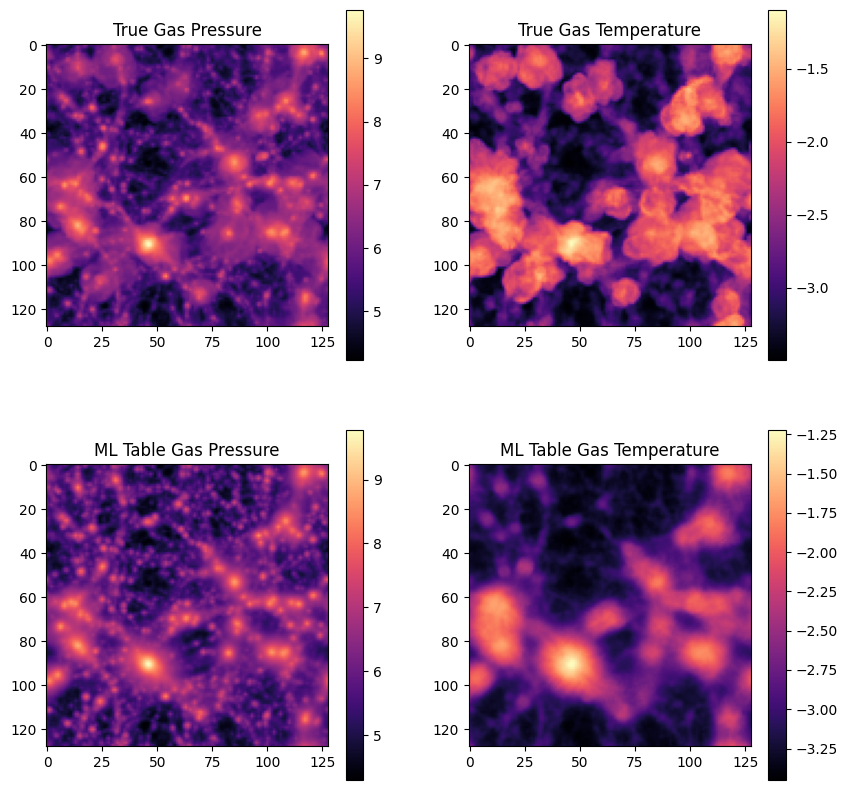

In [19]:
def paint_log_sum(positions, weights):
    return np.log10(cic_paint(jnp.zeros(mesh_shape), positions, weights).sum(axis=0))

plt.figure(figsize=[10,10])

plt.subplot(221)
im1 = plt.imshow(paint_log_sum(hydro_gas_pos, hydro_gas_P/hydro_gas_rho), cmap='magma')
plt.colorbar(im1)
plt.title('True Gas Pressure')

plt.subplot(222)
im2 = plt.imshow(paint_log_sum(hydro_gas_pos, hydro_gas_T/hydro_gas_rho), cmap='magma')
plt.colorbar(im2)
plt.title('True Gas Temperature')

plt.subplot(223)
im3 = plt.imshow(paint_log_sum(hydro_gas_pos, 10**preds[:,0]/hydro_gas_rho), cmap='magma')
plt.colorbar(im3)
plt.title('ML Table Gas Pressure')

plt.subplot(224)
im4 = plt.imshow(paint_log_sum(hydro_gas_pos, 10**preds[:,1]/hydro_gas_rho), cmap='magma')
plt.colorbar(im4)
plt.title('ML Table Gas Temperature')